In [1]:
import torch
class a_opt(torch.optim.lr_scheduler.LRScheduler):
    def __init__(self, x):
        pass
        
model = torch.nn.LSTM(100, 100)
c = a_opt(torch.optim.AdamW(model.parameters(), lr=0.1))
isinstance(c, torch.optim.lr_scheduler.LRScheduler)

True

In [2]:
import torch
class outProd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, branch, trunk):
        b, p = branch.shape[0], trunk.shape[0]
        branch = branch.expand(b, p)
        trunk = trunk.expand(b, p)
        ctx.save_for_backward(branch, trunk)
        return branch * trunk
    @staticmethod
    def backward(ctx, grad_output):
        branch, trunk = ctx.saved_tensors
        grad_input = grad_output.clone()
        print(grad_input.shape, branch.shape, trunk.shape)
        branch_grad = grad_input * trunk
        trunk_grad = grad_input * branch
        print(branch_grad.shape, trunk_grad.shape)
        return branch_grad, trunk_grad


x = torch.ones(10, 1)
y = torch.linspace(0, 1, 10)[...,None].requires_grad_()
a = outProd.apply(x,y)
print(a)
torch.autograd.grad(a, y, grad_outputs= torch.ones_like(a),retain_graph=True)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.1111],
        [0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222,
         0.2222],
        [0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
         0.3333],
        [0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444,
         0.4444],
        [0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556,
         0.5556],
        [0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
         0.6667],
        [0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778,
         0.7778],
        [0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889,
         0.8889],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]], grad_fn=<

(tensor([[10.],
         [10.],
         [10.],
         [10.],
         [10.],
         [10.],
         [10.],
         [10.],
         [10.],
         [10.]]),)

In [3]:
x = torch.ones(10, 1)
y = torch.linspace(0, 1, 10)[None,...].requires_grad_()
a = torch.outer(x, y)

RuntimeError: outer: Expected 1-D argument self, but got 2-D

In [ ]:
a = torch.ones(10, 10)
b = torch.linspace(0, 1, 10)[None,...]
print(a * b)

In [ ]:
import torch.nn as nn
class originDeepONetCard(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Linear(1, 10)
        self.trunk = nn.Linear(1, 10)
    def forward(self, x):
        branch = self.branch(x[0])
        trunk = self.trunk(x[1])
        out = torch.einsum("b i, p i -> b p", branch, trunk)
        return out
    
class DeepONetCard(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Linear(1, 10)
        self.trunk = nn.Linear(1, 10)
    def forward(self, x):
        p, b = x[1].shape[0], x[0].shape[0]
        branch = self.branch(x[0])
        trunk = self.trunk(x[1])
        branch = branch.unsqueeze(1).expand(b, p, 10)
        trunk = trunk.unsqueeze(0).expand(b, p, 10)
        return (branch * trunk).sum(-1)
    
netA = originDeepONetCard()
netB = DeepONetCard()
a = torch.ones(10, 1)
b = torch.linspace(0, 1, 10)[..., None].requires_grad_()
x = (a, b)
A = netA(x)
B = netB(x)
print(torch.autograd.grad(A, b, grad_outputs= torch.ones_like(A),retain_graph=True)[0])
print(torch.autograd.grad(B, b, grad_outputs= torch.ones_like(B),retain_graph=True)[0])

In [ ]:
import torch
from torch import nn
import time
class net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Linear(10, 1)
    
    def forward(self, x):
        return self.a(x)

y = net()
a = torch.randn(1, 10, requires_grad=True)
a = a.expand(1000, 10)
b = a.mean(0, keepdim=True)
out = y(a)
print(out.shape)
grad_batched = torch.eye(1000)[...,None]
grad = torch.autograd.grad(out, a, grad_outputs= grad_batched,retain_graph=True, is_grads_batched=True)[0]
print(grad)
for i in y.parameters():
    print(i)

torch.Size([1000, 1])
tensor([[[ 0.0016, -0.0471, -0.2148,  ..., -0.0615,  0.2788,  0.0963],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0016, -0.0471, -0.2148,  ..., -0.0615,  0.2788,  0.0963],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0

In [ ]:
import torch
from torch import nn
import time
class DeepOnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Linear(10, 10)
        self.trunk = nn.Linear(1, 10)
    
    def forward(self, b, t, mode = "a"):
        if mode == "a":
            branch = self.branch(b)
            trunk = self.trunk(t)
            return torch.einsum("b i, p i -> b p", branch, trunk)
        else:
            t = t.mean(0) # p, 1
            branch = self.branch(b) # b, 10
            trunk = self.trunk(t) # p, 10
            return torch.einsum("b i, p i -> b p", branch, trunk)

batch = 600
y = DeepOnet().cuda()
trunk_inp = torch.randn(1000, 1, requires_grad=True, device="cuda")
branch_inp = torch.randn(batch, 10, requires_grad=True, device="cuda")
out = y(branch_inp, trunk_inp, mode="a")

# 1000 x 1000 x 1; b, p, 1

In [ ]:
torch.cuda.empty_cache()
t = time.time()
grad2 = []
for i in out:
    grad2.append(torch.autograd.grad(i, trunk_inp, grad_outputs= torch.ones_like(i),retain_graph=True, create_graph=True)[0])
grad2 = torch.stack(grad2)
print(torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated())
print(grad2.shape)
#print(grad2)
print(time.time() - t)

1487258112 1489715712
torch.Size([600, 1000, 1])
12.440793752670288


In [ ]:
torch.cuda.empty_cache()
t = time.time()
for i in range(1):
    out = y(branch_inp, trunk_inp, mode="a")

grad_batched = torch.eye(batch, device = "cuda")[...,None].expand(batch, batch, 1000)
print(grad_batched.shape, out.shape)
grad3 = torch.autograd.grad(out, trunk_inp, grad_outputs= grad_batched,retain_graph=True, is_grads_batched= True, create_graph=True)[0]
print(torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated())
print(grad3.shape)

print(time.time() - t)

torch.Size([600, 600, 1000]) torch.Size([600, 1000])
48334848 1486678016
torch.Size([600, 1000, 1])
0.022984743118286133


In [ ]:
print((grad2 - grad3 > 1e-6).sum())

tensor(0, device='cuda:0')


(505,) (1, 101)
[0.         0.01558267 0.03116155 0.04673286 0.06229283 0.07783767
 0.09336361 0.10886687 0.1243437  0.13979034 0.15520303 0.17057803
 0.18591161 0.20120004 0.21643961 0.23162663 0.2467574  0.26182824
 0.27683551 0.29177555 0.30664474 0.32143947 0.33615613 0.35079117
 0.36534102 0.37980216 0.39417107 0.40844426 0.42261826 0.43668964
 0.45065498 0.46451088 0.47825398 0.49188094 0.50538846 0.51877326
 0.53203208 0.5451617  0.55815894 0.57102064 0.58374367 0.59632495
 0.60876143 0.62105008 0.63318791 0.64517198 0.65699939 0.66866725
 0.68017274 0.69151306 0.70268545 0.71368721 0.72451566 0.73516817
 0.74564216 0.75593509 0.76604444 0.77596778 0.78570268 0.79524679
 0.80459778 0.81375339 0.82271139 0.83146961 0.84002592 0.84837825
 0.85652456 0.86446287 0.87219126 0.87970786 0.88701083 0.89409841
 0.90096887 0.90762054 0.91405181 0.92026112 0.92624696 0.93200787
 0.93754246 0.94284938 0.94792735 0.95277512 0.95739153 0.96177546
 0.96592583 0.96984164 0.97352194 0.97696583 0

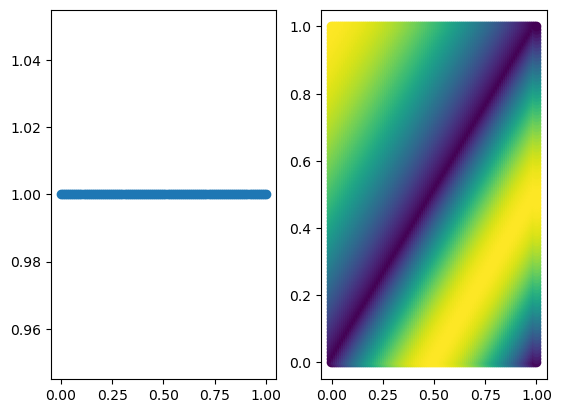

In [3]:
import deepxde.deepxde as dde
import numpy as np
f = dde.data.GRF(length_scale=0.1)
fea = f.random(1)
func = f.eval_batch(fea, np.linspace(0, 1, 101)[:, None])
func = np.ones((1, 101))
from datasets.solver import advection_solver
xt, u = advection_solver(func)

import matplotlib.pyplot as plt
fig , (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(np.linspace(0, 1, 101), func[0])
print(u[0])
xt2 = xt.reshape(-1, 2)
u2 = u.reshape(-1, 1)
ax2.scatter(xt2[:, 0], xt2[:, 1], c = u2)


In [4]:
u.T[0]

array([0.        , 0.03116155, 0.06229283, 0.09336361, 0.1243437 ,
       0.15520303, 0.18591161, 0.21643961, 0.2467574 , 0.27683551,
       0.30664474, 0.33615613, 0.36534102, 0.39417107, 0.42261826,
       0.45065498, 0.47825398, 0.50538846, 0.53203208, 0.55815894,
       0.58374367, 0.60876143, 0.63318791, 0.65699939, 0.68017274,
       0.70268545, 0.72451566, 0.74564216, 0.76604444, 0.78570268,
       0.80459778, 0.82271139, 0.84002592, 0.85652456, 0.87219126,
       0.88701083, 0.90096887, 0.91405181, 0.92624696, 0.93754246,
       0.94792735, 0.95739153, 0.96592583, 0.97352194, 0.98017249,
       0.98587102, 0.99061199, 0.99439081, 0.9972038 , 0.99904822,
       0.99992229, 0.99982516, 0.99875692, 0.99671861, 0.99371221,
       0.98974064, 0.98480775, 0.97891835, 0.97207814, 0.96429377,
       0.95557281, 0.94592371, 0.93535587, 0.92387953, 0.91150585,
       0.89824685, 0.88411539, 0.86912522, 0.85329088, 0.83662776,
       0.81915204, 0.8008807 , 0.78183148, 0.76202289, 0.74147

In [85]:
import torch

stat = torch.load("./results/adr_H1_norm_GRF_norm_19.pth")
print(stat.keys())

odict_keys(['branch.linears.0.weight', 'branch.linears.0.bias', 'branch.linears.1.weight', 'branch.linears.1.bias', 'trunk.linears.0.weight', 'trunk.linears.0.bias', 'trunk.linears.1.weight', 'trunk.linears.1.bias', 'trunk.linears.2.weight', 'trunk.linears.2.bias'])


In [88]:
stat = torch.load("./results/adr_pial_300000.pth")
print(stat.keys())

odict_keys(['branch.linears.0.weight', 'branch.linears.0.bias', 'branch.linears.1.weight', 'branch.linears.1.bias', 'trunk.linears.0.weight', 'trunk.linears.0.bias', 'trunk.linears.1.weight', 'trunk.linears.1.bias', 'trunk.linears.2.weight', 'trunk.linears.2.bias'])


In [89]:
print(stat['trunk.linears.0.weight'].shape)
print(stat['branch.linears.0.weight'].shape)

torch.Size([512, 2])
torch.Size([512, 100])


In [91]:
import deepxde.deepxde as dde
import numpy as np
import torch
from datasets import solver

def periodic(x):
    # print( "shape",torch.sin(x[:, 0] * 2 * np.pi).shape)
    return torch.cat((torch.cos(x[:, 0] * 2 * np.pi).reshape(-1, 1), torch.sin(x[:, 0] * 2 * np.pi).reshape(-1, 1),
                      torch.cos(2 * x[:, 0] * 2 * np.pi).reshape(-1, 1), torch.sin(2 * x[:, 0] * 2 * np.pi).reshape(-1, 1), x[:, 1].reshape(-1, 1)), 1)

fsp = dde.data.GRF(length_scale = 0.05)
fea = fsp.random(1)
vx = fsp.eval_batch(fea, np.linspace(0, 1, 100))

net = dde.nn.DeepONetCartesianProd(
    [100, 100, 100],
    [5, 100, 100, 100],
    "gelu",
    "Glorot normal",
)

net.apply_feature_transform(periodic)

net.load_state_dict(stat, strict = False)
print(vx.shape)
xt, u = solver.diffusion_reaction_solver(vx[0], Nx = 100, Nt = 100)
print(xt.shape)
print(u.shape)



geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

xt_uniform = xt.reshape(-1, 2)
#xt_uniform = geomtime.uniform_points(10000)
inputs = (torch.as_tensor(vx), torch.as_tensor(xt_uniform).float())
# print(inputs[0], inputs[1])
up = net(inputs)

RuntimeError: Error(s) in loading state_dict for DeepONetCartesianProd:
	size mismatch for branch.linears.0.weight: copying a param with shape torch.Size([512, 100]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for branch.linears.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for branch.linears.1.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for branch.linears.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for trunk.linears.0.weight: copying a param with shape torch.Size([512, 2]) from checkpoint, the shape in current model is torch.Size([100, 5]).
	size mismatch for trunk.linears.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for trunk.linears.1.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for trunk.linears.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for trunk.linears.2.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for trunk.linears.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([100]).

In [82]:
print(u.shape, up.shape)
u_p = up[0].detach().cpu().numpy()
u_t = u.flatten()
print(u_p.shape, u_t.shape)

(100, 100) torch.Size([1, 10000])
(10000,) (10000,)


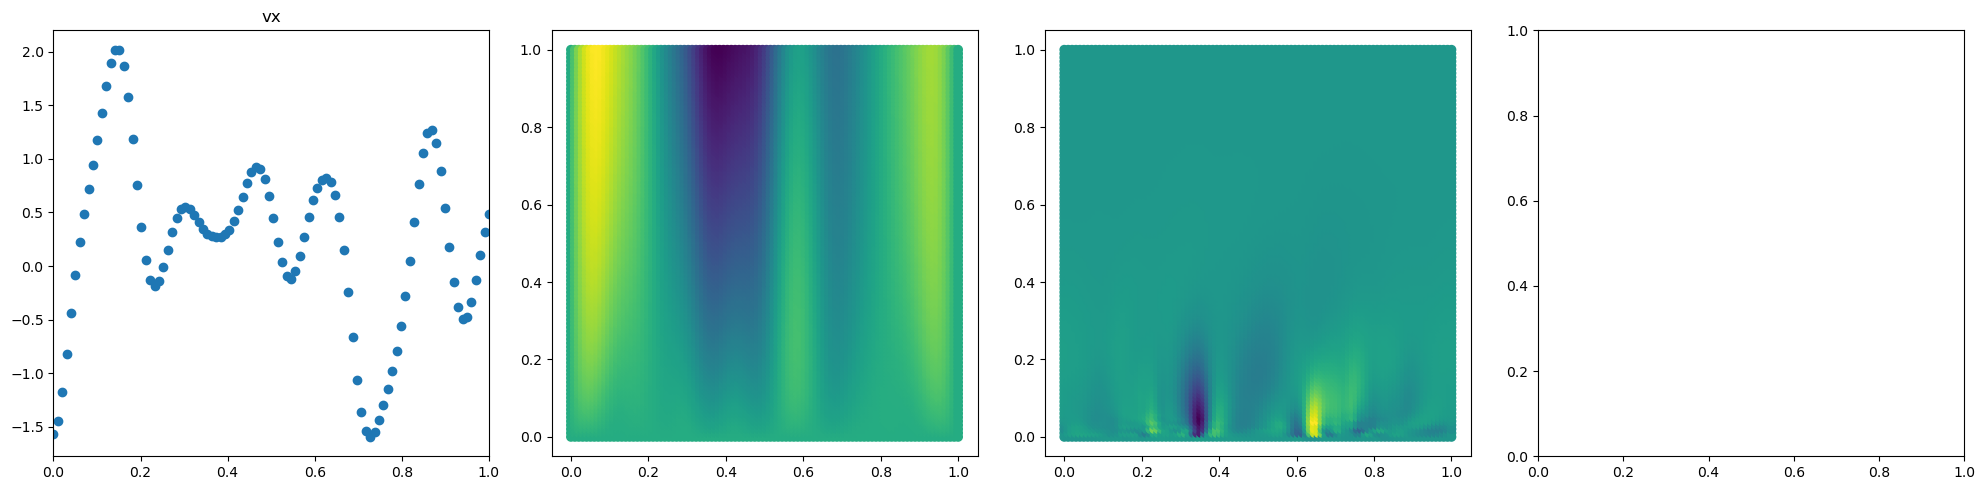

In [87]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.scatter(np.linspace(0, 1, 100), vx[0])
ax2.scatter(x = xt_uniform[:, 0], y = xt_uniform[:, 1], c = u_t)
ax3.scatter(x = xt_uniform[:, 0], y = xt_uniform[:, 1], c = u_p)
ax1.set_title("vx")
ax1.set_xlim(0, 1)
ax2.set_aspect("equal")
ax3.set_aspect("equal")
ax4.set_aspect("equal")
plt.tight_layout()
plt.show()
